In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "../dataset/1000_ocr_with_inference.csv"
df = pd.read_csv(FILE)
df['extracted_texts'] = df['extracted_texts'].apply(lambda x: eval(x))
df.rename(columns={'final_ext_val': 'llama_output'}, inplace=True)
df.drop(columns=['extracted_value'], inplace=True)
df.head()

,image_link,group_id,entity_name,entity_value,extracted_texts,number_in_extracted_text,llama_output
0,https://m.media-amazon.com/images/I/51H9wnjdA+...,941818,depth,30.0 centimetre,"[11.5CM, 30CM, 10CM]",True,30CM
1,https://m.media-amazon.com/images/I/615+YUQO7S...,894418,depth,14.9 inch,"[10.1inch, 120, 13.4inch, 14.9inch]",True,Since the information provided does not specif...
2,https://m.media-amazon.com/images/I/51USFZYcyB...,455402,height,14.9 inch,"[7.86 in/20cm, 14.9 in/38 cm]",True,7.86 in
3,https://m.media-amazon.com/images/I/71qoJgp38F...,459516,item_weight,100 gram,"[100%PURE, 100%, 100 g, Ingredients:100%Pure &...",True,2-4 grams
4,https://m.media-amazon.com/images/I/51cs4enkA0...,916768,depth,10.63 inch,"[10.63 in, 10.63 in]",True,10.63 inch


In [37]:
# replace nan values of llama_output with empty string
df['llama_output'] = df['llama_output'].apply(lambda x: x if isinstance(x, str) else '')

In [38]:
entity_unit_map = {
  "width": {
    "centimetre" : ["centimetre", "centimeter", "cm"],
    "foot": ["foot", "ft"],
    "millimetre": ["millimetre", "millimeter", "mm"],
    "metre": ["metre", "meter", "m"],
    "inch": ["inch", "in"],
    "yard": ["yard", "yd"]
  },
  "depth": {
    "centimetre": ["centimetre", "centimeter", "cm"],
    "foot": ["foot", "ft"],
    "millimetre": ["millimetre", "millimeter", "mm"],
    "metre": ["metre", "meter", "m"],
    "inch": ["inch", "in"],
    "yard": ["yard", "yd"]
  },
  "height": {
    "centimetre": ["centimetre", "centimeter", "cm"],
    "foot": ["foot", "ft"],
    "millimetre": ["millimetre", "millimeter", "mm"],
    "metre": ["metre", "meter", "m"],
    "inch": ["inch", "in"],
    "yard": ["yard", "yd"]
  },
  "item_weight": {
    "milligram": ["milligram", "mg"],
    "kilogram": ["kilogram", "kg"],
    "microgram": ["microgram", "µg", "mcg"],
    "gram": ["gram", "g"],
    "ounce": ["ounce", "oz"],
    "ton": ["ton", "t"],
    "pound": ["pound", "lb", "lbs"]
  },
  "maximum_weight_recommendation": {
    "milligram": ["milligram", "mg"],
    "kilogram": ["kilogram", "kg"],
    "microgram": ["microgram", "µg", "mcg"],
    "gram": ["gram", "g", "gm"],
    "ounce": ["ounce", "oz"],
    "ton": ["ton", "t"],
    "pound": ["pound", "lb", "lbs"]
  },
  "voltage": {
    "millivolt": ["millivolt", "mv"],
    "kilovolt": ["kilovolt", "kv"],
    "volt": ["volt", "v"]
  },
  "wattage": {
    "kilowatt": ["kilowatt", "kw"],
    "watt": ["watt", "w"]
  },
  "item_volume": {
    "cubic foot": ["cubic foot", "cubic ft"],
    "microlitre": ["microlitre", "microliter", "µl"],
    "cup": ["cup", "cups"],
    "fluid ounce": ["fluid ounce", "fl oz", "floz"],
    "centilitre": ["centilitre", "centiliter", "cl"],
    "imperial gallon": ["imperial gallon", "gal (UK)"],
    "pint": ["pint", "pt"],
    "decilitre": ["decilitre", "deciliter", "dl"],
    "litre": ["litre", "liter", "L"],
    "millilitre": ["millilitre", "milliliter", "ml"],
    "quart": ["quart", "qt"],
    "cubic inch": ["cubic inch", "cubic in"],
    "gallon": ["gallon", "gal"]
  }
}

In [39]:
import regex as re

def extract_number(text, entity):
    if type(text) == float:
        print(text)
    text = text.lower()
    possible_matches = []
    # replace comma with .
    text = text.replace(',', '.')
    # find all number unit pairs
    for unit in entity_unit_map[entity]:
        for unit_name in entity_unit_map[entity][unit]:
            pattern = r'(\d+\.?\d*)\s*'+unit_name
            match = re.search(pattern, text)
            if match:
                possible_matches.append((match.group(1), unit))

    possible_matches = list(set(possible_matches))

    return possible_matches

def extract_matches(extracted_texts, entity):
    matches = []
    for text in extracted_texts:
        matches.extend(extract_number(text, entity))
    return list(set(matches))

In [40]:
df["regex_matches"] = df.apply(lambda x: extract_matches(x["extracted_texts"], x["entity_name"]), axis=1)
df["llama_matches"] = df.apply(lambda x: extract_number(x["llama_output"], x["entity_name"]), axis=1)

In [41]:
default_unit_map = {
    "width": "centimetre",
    "depth": "centimetre",
    "height": "centimetre",
    "item_weight": "gram",
    "maximum_weight_recommendation": "kilogram",
    "voltage": "volt",
    "wattage": "watt",
    "item_volume": "litre"
    }

In [42]:
def handle_no_llama_matches(entity_name, extracted_texts, regex_matches):
    if len(regex_matches) > 4:
        return "", "-1"
    
    # choose a random number from the extracted texts
    for text in extracted_texts:
        match = re.search(r'(\d+\.?\d*)', text)
        if match:
            # round to 1 decimal place
            num = float(match.group(1))
            num = '{:.3f}'.format(round(num, 3))
            
            return str(num) + ' ' + default_unit_map[entity_name], "no_llama"
    
    return "", "-1"


def handle_non_singular_regex_matches(llama_matches, entity_name, extracted_texts, regex_matches):
    if len(llama_matches) == 0:
        return handle_no_llama_matches(entity_name, extracted_texts, regex_matches)
    if len(llama_matches) == 1:
        num = float(llama_matches[0][0])
        num = '{:.3f}'.format(round(num, 3))
        return str(num) + ' ' + llama_matches[0][1], "llama"
    
    return "", "-1"

def predict_entity(regex_matches, llama_matches, entity_name, extracted_texts):
    if len(regex_matches) == 1:
        num = float(regex_matches[0][0])
        num = '{:.3f}'.format(round(num, 3))
        return str(num) + ' ' + regex_matches[0][1], "regex"
    
    return handle_non_singular_regex_matches(llama_matches, entity_name, extracted_texts, regex_matches)   

In [43]:
df["prediction"] = df.apply(lambda x: predict_entity(x["regex_matches"], x["llama_matches"], x["entity_name"], x["extracted_texts"])[0], axis=1)
df["source"] = df.apply(lambda x: predict_entity(x["regex_matches"], x["llama_matches"], x["entity_name"], x["extracted_texts"])[1], axis=1)

In [44]:
def run_evaluation(df):
    
    def eval_prediction(prediction, entity_value):
        # if entity value is not of the form Num Unit, return 0
        if len(entity_value.split()) != 2 or len(prediction.split()) != 2:
            return 0
        
        # check the float values and units are the same
        pred_num, pred_unit = prediction.split()
        entity_num, entity_unit = entity_value.split()

        if pred_unit == entity_unit:
            pred_num = float(pred_num)
            entity_num = float(entity_num)
            if pred_num == entity_num:
                return 1
            
        return 0
    
    df["eval"] = df.apply(lambda x: eval_prediction(x["prediction"], x["entity_value"]), axis=1)

    # a true positive is when float value and unit are both correct
    # a false positive is when ground truth is empty and predicted value is not empty
    # a false negative is when ground truth is not empty and predicted value is empty
    # a true negative is when both ground truth and predicted value are empty

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for index, row in df.iterrows():
        if row["entity_value"] == "" and row["prediction"] == "":
            true_negatives += 1
        elif row["entity_value"] == "" and row["prediction"] != "":
            false_positives += 1
        elif row["entity_value"] != "" and row["prediction"] == "":
            false_negatives += 1
        elif row["entity_value"] != "" and row["prediction"] != "" and row["eval"] == 1:
            true_positives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    return df, {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [45]:
df, metrics = run_evaluation(df)
print(metrics)

{'precision': 1.0, 'recall': 0.7815884476534296, 'f1': 0.8774062816616008, 'accuracy': 0.7815884476534296}


<Axes: xlabel='source'>

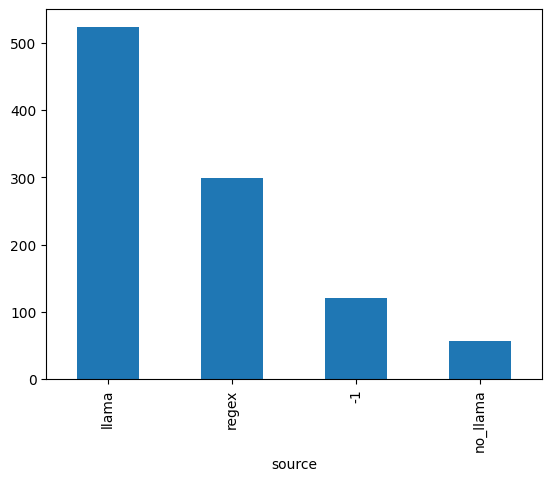

In [46]:
# plot the distribution of the source of the predictions
df["source"].value_counts().plot(kind='bar')

In [52]:
# get failure cases of llama
df[(df["source"] == "llama") & (df["eval"] == 0)].iloc[10:20]

,image_link,group_id,entity_name,entity_value,extracted_texts,number_in_extracted_text,llama_output,regex_matches,llama_matches,prediction,source,eval
22,https://m.media-amazon.com/images/I/71BX-m5-Gp...,601746,item_weight,4.0 ounce,"[1. Align the ball and insert it, 2. Align the...",True,1 ounce,[],"[(1, ounce)]",1.000 ounce,llama,0
25,https://m.media-amazon.com/images/I/41YZ0vlitI...,347320,depth,7.0 centimetre,[7cm/2.76in],True,2.76in,"[(7, centimetre), (2.76, inch)]","[(2.76, inch)]",2.760 inch,llama,0
26,https://m.media-amazon.com/images/I/715wC+BPTd...,308856,item_weight,4.4 pound,"[2kg, 4,4Lbs]",False,2kg,"[(4.4, pound), (2, kilogram)]","[(2, kilogram)]",2.000 kilogram,llama,0
30,https://m.media-amazon.com/images/I/610AbCBRlQ...,630869,depth,6.6 inch,"[3000, 6.6""]",True,3000 centimetre,[],"[(3000, centimetre)]",3000.000 centimetre,llama,0
33,https://m.media-amazon.com/images/I/51k7gfPkrr...,810266,height,17.0 centimetre,"[520ML, 8 CM, 17 CM]",True,8 CM,"[(520, metre), (8, centimetre), (17, centimetre)]","[(8, centimetre)]",8.000 centimetre,llama,0
35,https://m.media-amazon.com/images/I/51YzoZAW9B...,849273,height,41.0 centimetre,"[41CM, 9.5CM, 12.5CM]",True,12.5CM,"[(41, centimetre), (9.5, centimetre), (12.5, c...","[(12.5, centimetre)]",12.500 centimetre,llama,0
38,https://m.media-amazon.com/images/I/61-dPQg+yz...,478357,width,51.18 inch,"[51.18"", 220, 0.47"", 29.53"", 23.58"", 51 dia, 2...",True,"To find the width, I'll look for the informati...",[],"[(51, inch)]",51.000 inch,llama,0
39,https://m.media-amazon.com/images/I/51Hg+gO+9A...,459516,item_volume,100.0 millilitre,[],False,0 cubic inch,[],"[(0, cubic inch)]",0.000 cubic inch,llama,0
40,https://m.media-amazon.com/images/I/613-r5Xl0M...,941694,item_weight,25.0 gram,[],False,0 gram,[],"[(0, gram)]",0.000 gram,llama,0
45,https://m.media-amazon.com/images/I/6143KIkCiL...,993359,item_weight,100 gram,"[tomation (Per 00g.), 19.1g, 44.8g, Net Weight...",True,19.1g,"[(19.1, gram), (00, gram), (44.8, gram), (100,...","[(19.1, gram)]",19.100 gram,llama,0
